In [154]:
import satellighte as sat
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time
from matplotlib.image import imsave
from PIL import Image
from pathlib import Path
from torchvision import transforms as tt
from torchvision.transforms.transforms import Resize
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix

plt.rcParams["figure.figsize"] = (15, 15)

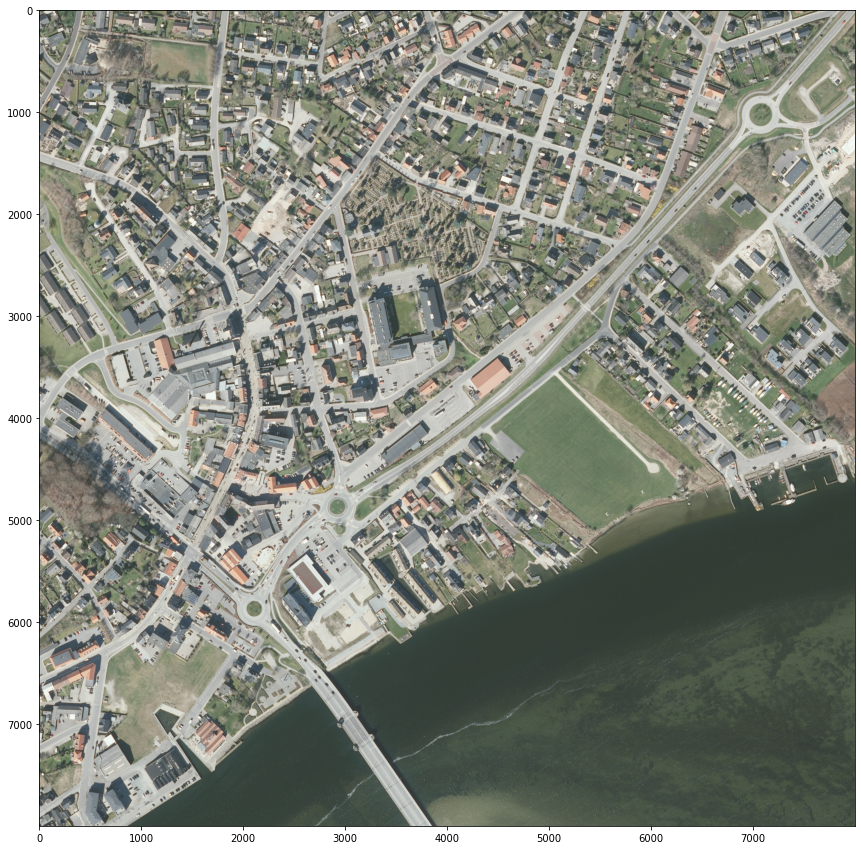

In [84]:
img_path = Path('../../../mnt/c/Users/dimit/Downloads/validation_data/02_validation_data_images/DQIMQN.png')
img = np.array(Image.open(img_path))
plt.imshow(img)
plt.show()

In [147]:
df_original_coordinates = pd.read_csv(str(img_path)[:-3]+'csv')
df_original_coordinates.head(5)

,label,y_target,x_target,y_upper_left,x_upper_left,y_lower_right,x_lower_right
0,trampoline,268,278,140,150,396,406
1,trampoline,1800,1492,1672,1364,1928,1620
2,trampoline,1639,1982,1511,1854,1767,2110
3,pond,2322,537,2194,409,2450,665
4,trampoline,5040,752,4912,624,5168,880


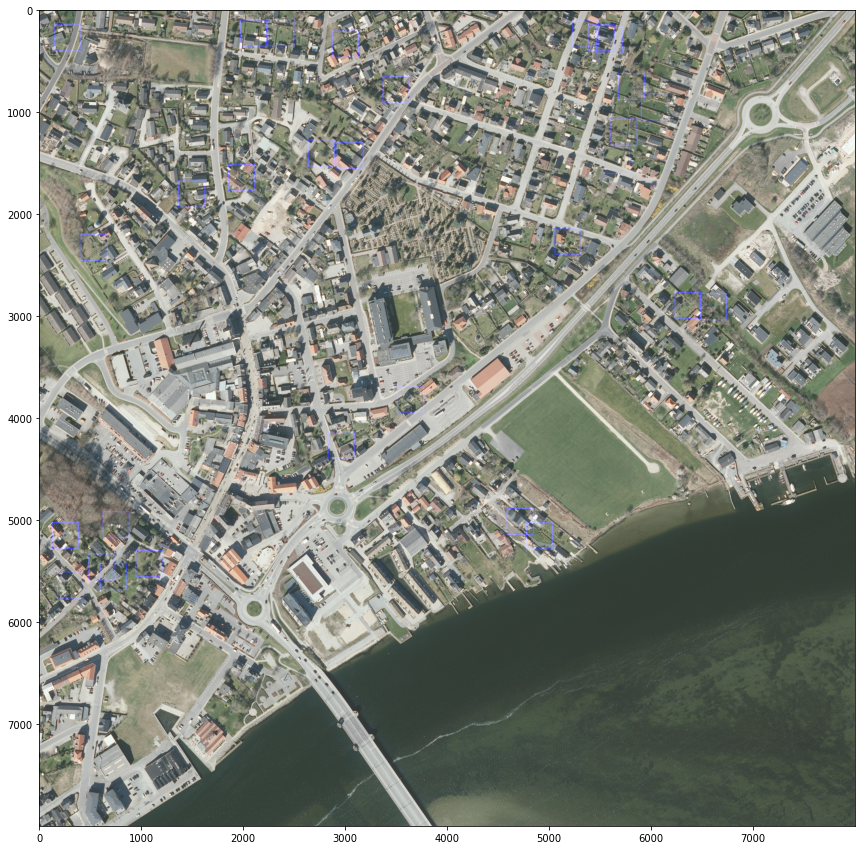

In [102]:
border = 10
img_first_classifications = img.copy()

for i, row in df_original_coordinates.iterrows():
    x_min = row['x_upper_left']
    x_max = row['x_lower_right']
    y_min = row['y_upper_left']
    y_max = row['y_lower_right']
    img_first_classifications[y_min:y_min+border, x_min:x_max,        2] = 255
    img_first_classifications[y_max:y_max+border, x_min:x_max,        2] = 255
    img_first_classifications[y_min:y_max,        x_min:x_min+border, 2] = 255
    img_first_classifications[y_min:y_max,        x_max:x_max+border, 2] = 255

plt.imshow(img_first_classifications)
plt.show()
imsave(str(img_path)[:-4] + '_original_coordinates.png', img_first_classifications)

In [155]:
def sliding_window(img, size=256, step=0.5):
    step = int(step*size)
    for i in np.arange(0, img.shape[0], step):
        for j in np.arange(0, img.shape[1], step):
            x_min = i 
            x_max = i + size
            y_min = j
            y_max = j + size
            if x_max > img.shape[0]:
                x_max = img.shape[0] - 1
                x_min = x_max - size 
            if y_max > img.shape[1]:
                y_max = img.shape[1] - 1
                y_min = y_max - size 
            yield (
                img[y_min:y_max, x_min:x_max, :], 
                int((y_max+y_min)/2),
                int((x_max+x_min)/2),
                y_min,
                x_min,
                y_max,
                x_max,
            )

In [111]:
model = torch.load('results/task_2/task_2_model_checkpoint_all_layers_round_5-v1.pt', map_location=torch.device('cpu'))

In [126]:
val_tt = tt.Compose([tt.ToPILImage(), tt.Resize((240, 240))])

In [127]:
labels_map = {
    'Industrial':           'trampoline',
    'Highway':              'solar',
    'HerbaceousVegetation': 'pools',
    'AnnualCrop':           'background',
    'Forest':               'ponds'
}

In [160]:
%%time

size    = 256
step    = 0.5
windows = sliding_window(img, size, step)
preds   = []

for window, y_target, x_target, y_upper_left, x_upper_left, y_lower_right, x_lower_right in windows:
    print('({}, {})'.format(y_target, x_target), end=', ')
    img_tt    = np.array(val_tt(window))[:, :, :3]
    dict_pred = model.predict(img_tt)[0]
    pred      = max(dict_pred, key=dict_pred.get)
    if pred != 'AnnualCrop':
        preds.append([
            labels_map.get(pred, 'background'),
            y_target,
            x_target,
            y_upper_left,
            x_upper_left,
            y_lower_right,
            x_lower_right
        ])

16min 18s


In [161]:
preds

[]